<center><h2>ALTeGraD 2024<br>Lab Session 2: Transfer learning for NLP</h2> 15 / 10 / 2024<br> Dr. G. Shang, Y. Zhang<br><br>


<b>Student name:</b> Lucas Versini

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 22, 2024 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(num_embeddings = ntoken, embedding_dim = nhid) # fill me (done), nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid = nhid, dropout = dropout) #fill me (done), the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(d_model = nhid, nhead = nhead, dim_feedforward = nhid) #fill me (done) we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer = encoder_layers, num_layers = nlayers) #fill me (done)
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src) #fill me (done)
        output = self.transformer_encoder(src, src_mask) #fill me (done)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses) #fill me (done)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout) #fill me (done)
        self.classifier = ClassificationHead(nhid, nclasses) #fill me (done)

    def forward(self, src, src_mask):
        # base model
        x = self.base(src, src_mask) #fill me (done)s
        # classifier model
        output = self.classifier(x) #fill me (done)
        return output

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [4]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape? Yes.

torch.Size([1, 6, 100])


/Data/lucas.versini/miniconda3/envs/RecVis2/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

In [6]:
nclasses = ntokens
model_modeling = Model(ntokens, nhead, nhid, nlayers, nclasses, dropout).to(device)

# Compute number of parameters
num_params = sum(p.numel() for p in model_modeling.parameters())
print(f"Number of parameters: {num_params}")

# Compute number of parameters
print(f"Number of parameters: {nhid * (ntokens + nlayers * (6 * nhid + 10)) + (1 + nhid) * nclasses}")

Number of parameters: 1008100
Number of parameters: 1008100


In [7]:
nclasses = 2
model_classification = Model(ntokens, nhead, nhid, nlayers, nclasses, dropout).to(device)

# Compute number of parameters
num_params = sum(p.numel() for p in model_classification.parameters())
print(f"Number of parameters: {num_params}")

# Compute number of parameters
print(f"Number of parameters: {nhid * (ntokens + nlayers * (6 * nhid + 10)) + (1 + nhid) * nclasses}")

Number of parameters: 988402
Number of parameters: 988402


## Vocabulary and Tokenization

In [8]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2024-10-17 19:22:23--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt.8’

dict.txt.8          100%[===================>] 564.05K  --.-KB/s    in 0.04s   

2024-10-17 19:22:23 (14.4 MB/s) - ‘dict.txt.8’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [9]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = idx + 4 #fill me (done)

ind2token = {v: k for k, v in token2ind.items()} #fill me

print(ind2token[1111])

▁trop


### Data Loader


In [10]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind["<sos>"]] \
                        + [self.token2ind.get(token, self.token2ind["<oov>"]) for token in sequence] #fill me (done) (constract the input sequence using token2ind, sequence and special tokens)
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [11]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1, :] #fill me (done)
        output = output.view(-1, output.shape[-1])
        target = data[1] #fill me (done)
        target = target.to(device)
        loss = criterion(output, target) #fill me (done), Cross entropy check next cells
        #fill me step 3 (done)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient
        #fill me step 4 (done)
        optimizer.step()

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [12]:
ntokens = len(token2ind) #fill me (done) # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [13]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2024-10-17 19:22:24--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt.6’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.1s    

2024-10-17 19:22:24 (76.3 MB/s) - ‘pretraining_subset.txt.6’ saved [10146460/10146460]



In [15]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task= "language_modeling", # fill me (done)
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.33071 | ppl 1526.465
| epoch   1 |  1000/ 3125 steps | loss 6.54673 | ppl  696.961
| epoch   1 |  1500/ 3125 steps | loss 6.26252 | ppl  524.537
| epoch   1 |  2000/ 3125 steps | loss 6.09489 | ppl  443.584
| epoch   1 |  2500/ 3125 steps | loss 5.96121 | ppl  388.079
| epoch   1 |  3000/ 3125 steps | loss 5.88294 | ppl  358.864
| epoch   2 |   500/ 3125 steps | loss 5.56218 | ppl  260.389
| epoch   2 |  1000/ 3125 steps | loss 5.51562 | ppl  248.545
| epoch   2 |  1500/ 3125 steps | loss 5.51737 | ppl  248.979
| epoch   2 |  2000/ 3125 steps | loss 5.47310 | ppl  238.198
| epoch   2 |  2500/ 3125 steps | loss 5.42798 | ppl  227.689
| epoch   2 |  3000/ 3125 steps | loss 5.39199 | ppl  219.640


## Text Generation


In [16]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2024-10-17 19:24:07--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt.2’

pretrained_model_4l 100%[===================>]  84.01M   105MB/s    in 0.8s    

2024-10-17 19:24:09 (105 MB/s) - ‘pretrained_model_4layers.pt.2’ saved [88093955/88093955]



/Data/lucas.versini/miniconda3/envs/RecVis2/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_1188298/961471251.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed

<All keys matched successfully>

In [17]:
# !pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2024-10-17 19:24:09--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model.2’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-10-17 19:24:10 (20.5 MB/s) - ‘sentencepiece.french.model.2’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [18]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = torch.argmax(out[-1, 0], axis = -1) #fill me (done)
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    # to be implemented (done)
    s = spm.SentencePieceProcessor(model_file = "sentencepiece.french.model")
    sent_pieces = s.encode_as_pieces(sent)
    while len(sent_pieces) < max_len:
        next_token_ind, _ = infer_next_token(s.decode_pieces(sent_pieces))
        next_token = ind2token[next_token_ind.item()]
        if next_token == "<eos>":
            break
        sent_pieces.append(next_token)
    return s.decode_pieces(sent_pieces)

In [19]:
sent = "Bonjour les"
infer_next_tokens(sent)

'Bonjour les gens qui ont été très accueillants et sympathiques.'

### Supervised task

In [20]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2024-10-17 19:24:10--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm.2’

train.review.spm.2  100%[===================>]   1.43M  --.-KB/s    in 0.05s   

2024-10-17 19:24:10 (26.8 MB/s) - ‘train.review.spm.2’ saved [1495960/1495960]

--2024-10-17 19:24:10--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request s

In [21]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    #to be implemented
    with torch.no_grad():
        correct, total = 0, 0
        model.eval()
        for data in data_loader:
            src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(device)
            input = data[0].to(device)
            output = model(input, src_mask)
            output = output[-1, :]
            predicted = torch.argmax(output, axis = -1)

            target = data[1]
            target = target.to(device)

            total += target.shape[0]
            correct += (predicted == target).sum().item()
        accuracy = correct / total
        print(f"Accuracy: {accuracy}")
        return accuracy

In [22]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [23]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.78911 | ppl    2.201
| epoch   1 |   100/  200 steps | loss 0.70492 | ppl    2.024
| epoch   1 |   150/  200 steps | loss 0.69422 | ppl    2.002
Accuracy: 0.6495
| epoch   2 |    50/  200 steps | loss 0.68526 | ppl    1.984
| epoch   2 |   100/  200 steps | loss 0.59391 | ppl    1.811
| epoch   2 |   150/  200 steps | loss 0.58286 | ppl    1.791
Accuracy: 0.632
| epoch   3 |    50/  200 steps | loss 0.49857 | ppl    1.646
| epoch   3 |   100/  200 steps | loss 0.39570 | ppl    1.485
| epoch   3 |   150/  200 steps | loss 0.39428 | ppl    1.483
Accuracy: 0.7535
| epoch   4 |    50/  200 steps | loss 0.15670 | ppl    1.170
| epoch   4 |   100/  200 steps | loss 0.11275 | ppl    1.119
| epoch   4 |   150/  200 steps | loss 0.15151 | ppl    1.164
Accuracy: 0.758
| epoch   5 |    50/  200 steps | loss 0.01290 | ppl    1.013
| epoch   5 |   100/  200 steps | loss 0.08877 | ppl    1.093
| epoch   5 |   150/  200 steps | 

/tmp/ipykernel_1188298/89992632.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")


| epoch   1 |    50/  200 steps | loss 0.83428 | ppl    2.303
| epoch   1 |   100/  200 steps | loss 0.69345 | ppl    2.001
| epoch   1 |   150/  200 steps | loss 0.62579 | ppl    1.870
Accuracy: 0.7505
| epoch   2 |    50/  200 steps | loss 0.54951 | ppl    1.732
| epoch   2 |   100/  200 steps | loss 0.50609 | ppl    1.659
| epoch   2 |   150/  200 steps | loss 0.47700 | ppl    1.611
Accuracy: 0.788
| epoch   3 |    50/  200 steps | loss 0.34667 | ppl    1.414
| epoch   3 |   100/  200 steps | loss 0.34764 | ppl    1.416
| epoch   3 |   150/  200 steps | loss 0.38025 | ppl    1.463
Accuracy: 0.7895
| epoch   4 |    50/  200 steps | loss 0.23097 | ppl    1.260
| epoch   4 |   100/  200 steps | loss 0.27285 | ppl    1.314
| epoch   4 |   150/  200 steps | loss 0.33629 | ppl    1.400
Accuracy: 0.786
| epoch   5 |    50/  200 steps | loss 0.22083 | ppl    1.247
| epoch   5 |   100/  200 steps | loss 0.20670 | ppl    1.230
| epoch   5 |   150/  200 steps | loss 0.18177 | ppl    1.199
Accu

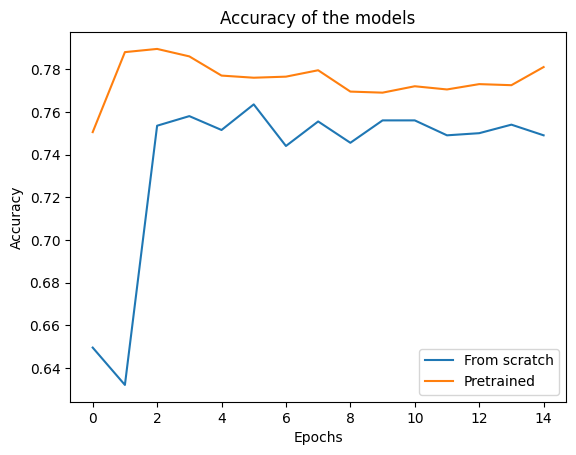

In [24]:
#Visualize the accuracy

import matplotlib.pyplot as plt

plt.plot(from_scratch_valid_acc, label = "From scratch")
plt.plot(pretrained_valid_acc, label = "Pretrained")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy of the models")

plt.show()